# Otoczka wypukła

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from bitalg.tests.test2 import Test
from bitalg.visualizer.main import Visualizer
from functools import cmp_to_key
from math import sqrt
from time import process_time

In [2]:
EPS = 0

### Wprowadzenie

Czym jest otoczka wypukła?  
Podzbiór płaszczyzny $Q$ nazywamy wypukłym iff, gdy dla dowolnej pary punktów $p, q \in Q$ odcinek $\overline{pq}$ jest całkowicie zawarty w $Q$.  
Otoczka wypukła $\mathcal{CH}(Q)$ zbioru $Q$ jest najmniejszym wypukłym zbiorem zawierającym $Q$.

### Zastosowania otoczku wypukłej

Otoczki wypukłe - w szczególności otoczki wypukłe w przestrzeni trójwymiarowej - są spotykane w różnych zastosowaniach. Na przykład używa się ich do przyspieszania wykrywania kolizji w animacji komputerowej. Przepuśćmy, że chcemy sprawdzić, czy dwa obiekty $\mathcal{P_1}$ i $\mathcal{P_2}$ przecinają się. Jeśli przez większość czasu odpowiedź na to pytanie jest negatywna, to opłaca się następująca strategia. Przybliżamy obiekty przez prostrze obiekty $\widehat{\mathcal{P_1}}$ i $\widehat{\mathcal{P_2}}$, które zawierały orginały. Jeśli chcemy sprwadzić, czy $\mathcal{P_1}$ i $\mathcal{P_2}$ przecinają się, najpierw sprawdzamy, czy przecinają się $\widehat{\mathcal{P_1}}$ i $\widehat{\mathcal{P_2}}$. Jeśli występuje ten przypadek, to powinniśmy wykonać test na orginalnych obiektach, który jest przepuszczalnie znacznie kosztowniejszy.  
Sprawdzanie przecięcia otoczek wypukłych jest bardziej skomplikowane niż dla sfer - choć mimo to łatwiejsze niż dla obiektów niewypukłych - ale otoczki wypukłe mogą dużo lepiej przybliżać większość obiektów.

## Generowanie losowych punktów na płaszczyźnie 

Zapoznaliśmy się i wiemy jak generowac losowe punkty na płaszczyźnie z laboratorium I (współrzędne rzeczywiste typu *double* - podwójna precyzja obliczeń). Przygotuj zestawy punktów, które będzie można użyć jako testowe dla algorytmów obliczania otoczki wypukłej.

Uzupełnij funkcję ```generate_uniform_points```.

In [3]:
def generate_uniform_points(left=-100, right=100, n=100):
    """
    Funkcja generuje równomiernie n punktów na kwadwratowym
    obszarze od left do right (jednakowo na osi y)
    o współrzędnych rzeczywistych
    :param left: lewy kraniec przedziału
    :param right: prawy kraniec przedziału
    :param n: ilość generowanych punktów
    :return: tablica punktów w postaci krotek współrzędnych
             np. [(x1, y1), (x2, y2), ... (xn, yn)]
    """
    return list(np.random.uniform(low = left, high = right, size = (n, 2)))

<span style="color:red">Ćw.</span> Wygeneruj $100$ losowych punktów w przestrzeni 2D o współrzędnych z przedziału $x \in \langle -100,100 \rangle$ oraz $y \in \langle -100,100\rangle$.

In [4]:
points_a = generate_uniform_points(-100, 100, 100)

Zwizualizuj wygenerowane punkty.

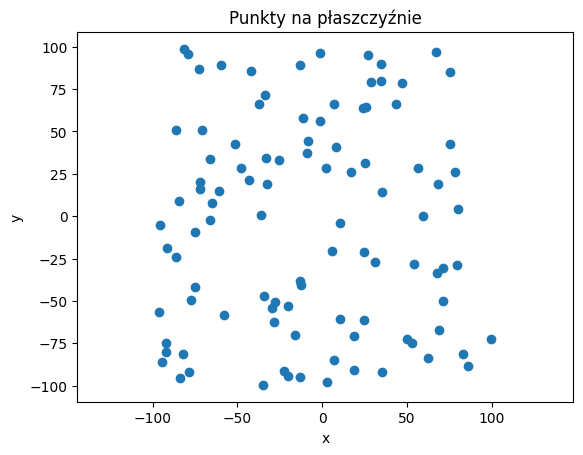

In [5]:
# visualize(points_a)
vis = Visualizer()
vis.add_title("Punkty na płaszczyźnie")
vis.add_point(points_a)
vis.axis_equal()
vis.show()
vis.save('plane')

Uzupełnij funkcję ```generate_circle_points```.

In [6]:
def generate_circle_points(O, R, n=100):
    """
    Funkcja generuje jednostajnie n punktów na okręgu o środku O i promieniu R
    :param O: krotka współrzędnych x, y określająca środek okręgu
    :param R: promień okręgu
    :param n: ilość generowanych punktów
    :return: tablica punktów w postaci krotek współrzędnych
    """
    def map_theta_to_points(theta, O, R):
        #funkcja pomocnicza, mapuje współrzędne biegunowe na współrzędne kartezjańskie
        return (O[0] + R * np.cos(theta), O[1] + R * np.sin(theta))
    
    theta_array = np.random.uniform(low = 0, high = 2 * np.pi, size = n)
    return [map_theta_to_points(theta, O, R) for theta in theta_array]

<span style="color:red">Ćw.</span> Wygeneruj $100$ losowych punktów w przestrzeni 2D leżących na okręgu o środku $O = (0,0)$ i promieniu $R = 10$.

In [7]:
points_b = generate_circle_points((0, 0), 10, 100)

Zwizualizuj wygenerowane punkty.

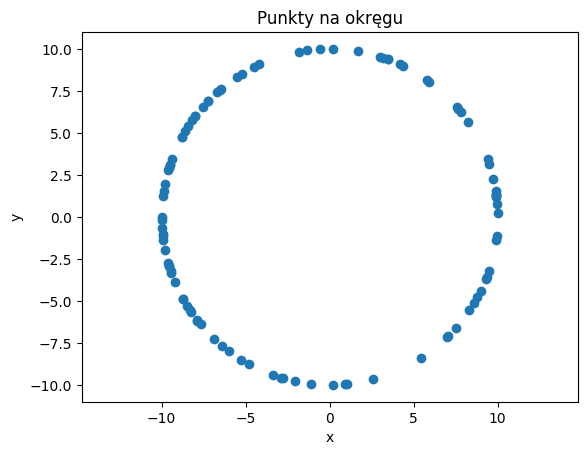

In [8]:
# visualize(points_b)
vis.clear()
vis.add_title("Punkty na okręgu")
vis.add_point(points_b)
vis.axis_equal()
vis.show()
vis.save('circle')

Jak można było zauważyć, to funkcje ```generate_uniform_points``` oraz ```generate_circle_points``` są takie same jak w laboratorium I.

Uzupełnij funkcję ```generate_rectangle_points```.

## Funkcje pomocnicze do obliczeń na wektorach

In [9]:
def get_vector(a, b):
    return np.array([b[0]-a[0], b[1]-a[1]])

def norm(v):
    return sqrt(v[0]**2 + v[1]**2)

def dist(p0, p1):
    return norm(get_vector(p0, p1))

def get_unit_vector(a, b):
    v = get_vector(a, b)
    return v/norm(v)

In [10]:
def generate_rectangle_points(a=(-10, -10), b=(10, -10), c=(10, 10), d=(-10, 10), n=100):
    '''
    Funkcja generuje n punktów na obwodzie prostokąta
    o wierzchołkach w punktach a, b, c i d
    :param a: lewy-dolny wierzchołek prostokąta
    :param b: prawy-dolny wierzchołek prostokąta
    :param c: prawy-górny wierzchołek prostokąta
    :param d: lewy-górny wierzchołek prostokąta
    :param n: ilość generowanych punktów
    :return: tablica punktów w postaci krotek współrzędnych
    '''
    ab = get_unit_vector(a, b)
    bc = get_unit_vector(b, c)
    cd = get_unit_vector(c, d)
    da = get_unit_vector(d, a)
    

    L = 2 * (dist(a, b) + dist(b, c))

    points = np.random.uniform(low = 0, high = L, size = n)

    def map_l_to_rect(l):

        if l < dist(a, b):
            return a + ab*l

        l -= dist(a, b)
        if l < dist(b, c):
            return b + bc * l

        l -= dist(b, c)
        if l < dist(c, d):
            return c + cd*l

        l -= dist(c, d)
        return d + da*l

    return [tuple(map_l_to_rect(p)) for p in points]

<span style="color:red">Ćw.</span> Wygeneruj $100$ losowych punktów w przestrzeni 2D leżących na obwodzie prostokąta, którego wyznaczają wierzchołki
$(-10,-10), (10,-10), (10,10)$ oraz $(-10,10)$.

In [11]:
points_c = generate_rectangle_points(
    (-10, -10), (10, -10), (10, 10), (-10, 10), 100)

Zwizualizuj wygenerowane punkty.

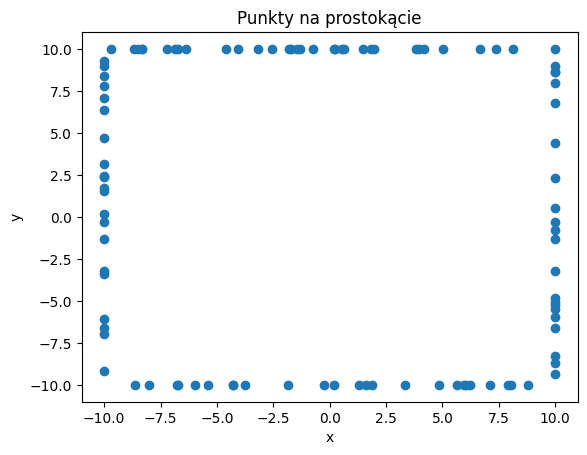

In [12]:
# visualize(points_c)
vis.clear()
vis.add_title("Punkty na prostokącie")
vis.add_point(points_c)
vis.show()
vis.save('rect')

Uzupełnij funkcję ```generate_square_points```.

In [13]:
def generate_square_points(a=(0, 0), b=(10, 0), c=(10, 10), d=(0, 10),
                           axis_n=25, diag_n=20):
    '''
    Funkcja generuje axis_n punktów na dwóch bokach kwadratu
    leżących na osiach x i y oraz diag_n punktów na
    przekątnych kwadratu, którego wyznaczają punkty
    a, b, c i d.
    :param a: lewy-dolny wierzchołek kwadratu
    :param b: prawy-dolny wierzchołek kwadratu
    :param c: prawy-górny wierzchołek kwadratu
    :param d: lewy-górny wierzchołek kwadratu
    :param axis_n: ilość generowanych punktów na każdym
                   z dwóch boków kwadratu równoległych do osi x i y
    :param diag_n: ilość generowanych punktów na każdej
                   przekątnej kwadratu
    :return: tablica punktów w postaci krotek współrzędnych
    '''
    axis_points = generate_rectangle_points(a,b,c,d,axis_n)

    ac = get_unit_vector(a, c)
    bd = get_unit_vector(b, d)

    def map_point(d, vector, start):
        return start + vector * d
    
    points_diag1 = [tuple(map_point(d, ac, a)) for d in np.random.uniform(low = 0, high = dist(a, c), size = diag_n)]
    points_diag2 = [tuple(map_point(d, bd, b)) for d in np.random.uniform(low = 0, high = dist(b, d), size = diag_n)]

    return axis_points + points_diag1 + points_diag2

<span style="color:red">Ćw.</span> Wygeneruj losowe punktów w przestrzeni 2D w następujący sposób: po 25 punktów na dwóch bokach kwadratu leżących na osiach i po 20 punktów na przekątnych kwadratu, zawierający punkty wyznaczające kwadrat $(0, 0), (10, 0), (10, 10)$ oraz $(0, 10)$.

In [14]:
points_d = generate_square_points(
    (0, 0), (10, 0), (10, 10), (0, 10), 25, 20)

Zwizualizuj wygenerowane punkty.

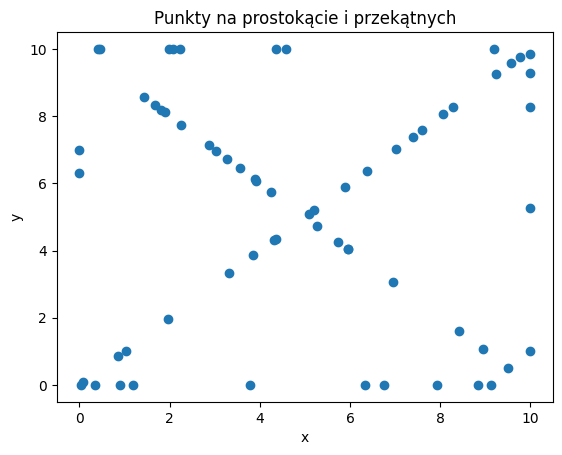

In [15]:
# visualize(points_d)
vis.clear()
vis.add_title('Punkty na prostokącie i przekątnych')
vis.add_point(points_d)
vis.show()
vis.save('rect_diag')

## Algorytm Grahama oraz algorytm Jarvisa

Po przygotowaniu przykładowych zbiorów danych i ich zwizualizowaniu, chcemy zobaczyć jak buduje się dla nich otoczka wypukła z wykorzystaniem różnych algortymów.  
W tych dwóch algorytmach potrzebna będzie funkcja którą już dobrze znamy, czyli funkcja, która sprawdza po której stornie prostej znajduje się punkt.  
Dla każdego algorytmu trzeba będzie zaimplementować dwie funkcje obliczające otoczkę wypukłę, ze względu, że jedna z nich będzie miała możliwość wyświetlania kroków postępowania w algorytmie. Druga funkcja będzie uzyteczna do porównywania czasów dla różnych zbiorów danych i względęm algorytmów.  
W graficznej funkcji danego algorytmu, jednym kolorem powinny być zaznaczone wszystkie punkty zbioru wyjściowego, drugim kolorem boki aktualne rozpatrywane, a trzecim boki wielokąta otoczki. Po zakończeniu wyznaczania otoczki, wierzchołki otoczki powinny być wyróżnione (osobnym kolorem bądź kształtem).  

### Algorytm Grahama

Algorytm Grahama tworzy otoczkę wypukłą poprzez utrzymywanie stosu $S$, w którym znajdują się punkty, które mogą, ale nie muszą tworzyć otoczki wypukłej. Za każdym razem jest wstawiany na stos (push) jeden punkt z zbioru punktów $Q$ i jest on usuwany ze stosu (pop), jeżeli nie jest punktem $\mathcal{CH}(Q)$. Kiedy algorytm kończy się, stos $S$ zawiera tylko punkty otoczki wypukłej $\mathcal{CH}(Q)$ w kierunku przeciwnym do ruchu wskazówek zegera.

---

Procedura $\mathtt{Graham-Build(Q)}$ przyjmuje zbiór punktów $Q$, gdzie $|Q| \geq 3$. Wywołuje ona funkcję $\mathtt{TOP(S)}$, która zwraca punkt z góry stosu bez zmieniania $S$ oraz
$\mathtt{NEXT-TO-TOP(S)}$, która zwraca punkt poniżej góry stosu $S$, bez zmieniania stosu. Funkcja $\mathtt{PUSH(p, S)}$ wstawia punkt $p$ na stos $S$. Funkcja $\mathtt{POP(p, S)}$ usuwa punkt $p$ ze stosu $S$.

$\mathtt{Graham-Build(Q)}$  
1)  niech $p_0$ będzie punktem w zbiorze Q z najmniejszą współrzędną $y$,  
    oraz najmniejszą współrzędną $x$ w przypadku, gdy wiele punktów ma tą samą współrzędną $x$  
    
2)  niech $\mathtt{\langle p_1, p_2, \dots, p_m \rangle}$ będzie pozostałym zbiorem punktów w $Q$ posortowanym  
    zgodnie z przeciwnym ruchem wskazówek zegara wokół punktu $p_0$  
    (jeżeli więcej niż jeden punkt ma ten sam kąt to usuwamy wszystkie punkty  
     z wyjątkiem tego najbardziej oddalonego od $p_0$)  
3) stwórz pusty stos $S$  
4) $\mathtt{PUSH(p_0, S)}$
5) $\mathtt{PUSH(p_1, S)}$
6) $\mathtt{PUSH(p_2, S)}$
7) **for** $i = 3$ **to** m  
8) &emsp;**while** kąt utworzony przez $\mathtt{NEXT-TO-TOP(S)}$, $\mathtt{TOP(S)}$ oraz $p_i$ tworzy lewostronny skręt
9) &emsp;&emsp;$\mathtt{POP(S)}$
10) &emsp;$\mathtt{PUSH(p_i, S)}$
11) **return** $S$


---

Lewostronny skręt oznacza, że dla trzech kolejnych punktów $a, b, c$, punkt $b$ leży po lewej stronie prostej $ac$.  
  

<span style="color:red">Ćw.</span> Uzupełnij funkcję ```graham_algorithm```, która oblicza otoczkę wypukłą korzystając z algorytmu Grahama.

In [16]:
def find_leftmost(Q):
    #funkcja znajduje punkt o najmniejszej wartości y i zwraca jego indeks
    ix = 0
    for i in range(1, len(Q)):
        x, y = Q[i]
        if y < Q[ix][1]: ix = i
        elif y == Q[ix][1] and x < Q[ix][0]: ix = i

    return ix

In [17]:
def orient(a, b, c):
    a_x, a_y = a
    b_x, b_y = b
    c_x, c_y = c

    a00, a01 = (a_x - c_x), (a_y - c_y)
    a10, a11 = (b_x - c_x), (b_y - c_y)

    det = a00 * a11 - a01 * a10
    if det > EPS: return 1
    if det < -EPS: return -1
    return 0
    
def cmp(a, b, c):
    return -orient(a, b, c)

def merge_sort(tab, cmp, p0):
    if len(tab) <= 1: return tab

    n = len(tab)
    tab_left = merge_sort(tab[:n//2], cmp, p0)
    tab_right = merge_sort(tab[n//2:], cmp, p0)

    result = []
    i, j = 0, 0
    while i < len(tab_left) and j < len(tab_right):
        p1 = tab_left[i]
        p2 = tab_right[j]
        c = cmp(p1, p2)
        if c < 0:
            result.append(p1)
            i += 1
        elif c > 0:
            result.append(p2)
            j += 1
        else:
            if dist(p0, p1) > dist(p0, p2):
                j += 1
            else:
                i += 1

    while i < len(tab_left): 
        result.append(tab_left[i])
        i += 1
    while j < len(tab_right):
        result.append(tab_right[j])
        j += 1

    return result

In [18]:
def graham_algorithm(Q):
    '''
    Funkcja buduje otoczkę wypukłą dla podanego
    zbioru punktów Q algorymem Grahama
    :param Q: zbiór punktów
    :return: tablica punktów w postaci krotek współrzędnych
    '''
    s_ix = find_leftmost(Q)
    s = Q[s_ix]
    Q.pop(s_ix)
    
    def sort_cmp(a, b):
        nonlocal s
        return -orient(s, a, b)

    Q = merge_sort(list(Q), sort_cmp, s)
    
    if len(Q) < 2: return [s] + list(Q)
    
    stack = [s, Q[0], Q[1]]
    for i in range(2, len(Q)):
        while len(stack) > 1 and cmp(stack[-2], stack[-1], Q[i]) >= 0:
            stack.pop()
        stack.append(Q[i])

    return stack

Przetestuj swoją implementacje algorytmu Grahama, by sprawdzić czy poprawnie obliczana jest otoczka.

In [19]:
Test().runtest(1, graham_algorithm)

Lab 2, task 1:
	Test 1: Passed
	Test 2: Passed
	Test 3: Passed
	Test 4: Passed
	Test 5: Passed
	Test 6: Passed
	Test 7: Passed
	Test 8: Passed
	Test 9: Passed
	Test 10: Passed
	Test 11: Passed
Result: 11/11
Time: 2.068s


<span style="color:red">Ćw.</span> Uzupełnij funkcję ```graham_algorithm_draw```, która oblicza otoczkę wypukłą korzystając z algorytmu Grahama z dodatkową opcją wyświetlania kroków algorytmu.

In [21]:
def graham_algorithm_draw(Q):
    '''
    Funkcja buduje otoczkę wypukłą dla podanego
    zbioru punktów Q algorymem Grahama oraz
    pokazuje poszczególne kroki algorymu
    :param Q: zbiór punktów
    :return: krotka w postaci (tablica punktów w postaci krotek współrzędnych,
                                wizualizer pokazujący kroki algorytmu) 
    '''
    vis = Visualizer()
    vis.add_title("Sposób działania algorymtu Grahama")
    vis.add_point(Q, color='blue', s=10)
    
    s_ix = find_leftmost(Q)
    s = Q[s_ix]
    Q.pop(s_ix)
    
    def sort_cmp(a, b):
        nonlocal s
        return -orient(s, a, b)

    Q = merge_sort(list(Q), sort_cmp, s)

    vis.add_point(s, color='red', s=10)
    
    if len(Q) < 2: 
        vis.add_point(Q, color='red', s=10)
        return [s] + list(Q), vis

    stack = [s, Q[0], Q[1]]
    vis.add_point(Q[0], color='red', s=10)
    vis.add_point(Q[1], color='red', s=10)
    stack_lines = []
    stack_lines.append(vis.add_line_segment([s, Q[0]], color='red'))
    stack_lines.append(vis.add_line_segment([Q[0], Q[1]], color='red'))
    
    for i in range(2, len(Q)):
        vis.add_point(Q[i], color='green', s=10)
        l = vis.add_line_segment([[Q[i], stack[-2]], [Q[i], stack[-1]]], color='green')
        
        while len(stack) > 1 and cmp(stack[-2], stack[-1], Q[i]) >= 0:
            vis.remove_figure(l)

            vis.add_point(stack[-1], color='blue', s=10)
            stack.pop()
            vis.remove_figure(stack_lines[-1])
            stack_lines.pop()
            if len(stack) > 1:
                l = vis.add_line_segment([[Q[i], stack[-2]], [Q[i], stack[-1]]], color='green')

        if len(stack) > 1: 
            vis.remove_figure(l)
            
        vis.add_point(Q[i], color='red', s=10)
        stack_lines.append(vis.add_line_segment([stack[-1], Q[i]], color='red'))
        stack.append(Q[i])

    vis.add_line_segment([stack[-1], stack[0]], color='red')
    
    return stack, vis

Zwizualizuj swoją implementację algorytmu.

Zbiór danych A

In [22]:
graham_points_a, vis_graham_a = graham_algorithm_draw(points_a[:])

In [23]:
vis_graham_a.save_gif(filename='graham_plane', interval=400)#show_gif(interval=400)

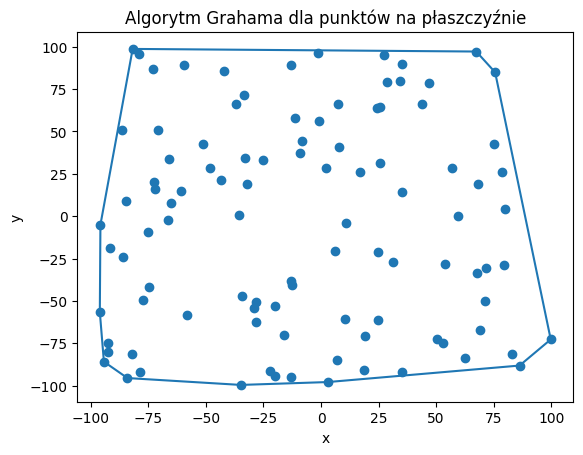

In [24]:
# visualize(graham_points_a)
vis.clear()
vis.add_title("Algorytm Grahama dla punktów na płaszczyźnie")
vis.add_point(points_a)
vis.add_line_segment([(graham_points_a[i], graham_points_a[i+1]) for i in range(len(graham_points_a)-1)])
vis.add_line_segment([graham_points_a[-1], graham_points_a[0]])
vis.show()

Zbiór danych B

In [25]:
graham_points_b, vis_graham_b = graham_algorithm_draw(points_b[:])

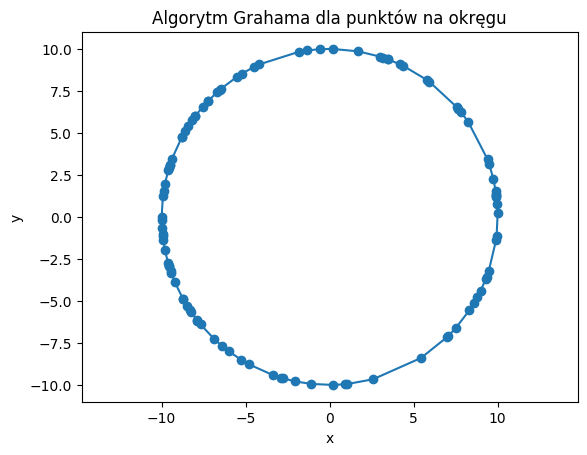

In [43]:
# visualize(graham_points_b)
vis.clear()
vis.add_title("Algorytm Grahama dla punktów na okręgu")
vis.add_point(points_b)
vis.add_line_segment([(graham_points_b[i], graham_points_b[i+1]) for i in range(len(graham_points_b)-1)])
vis.add_line_segment([graham_points_b[-1], graham_points_b[0]])
vis.axis_equal()
vis.show()

Zbiór danych C

In [27]:
graham_points_c, vis_graham_c = graham_algorithm_draw(points_c[:])

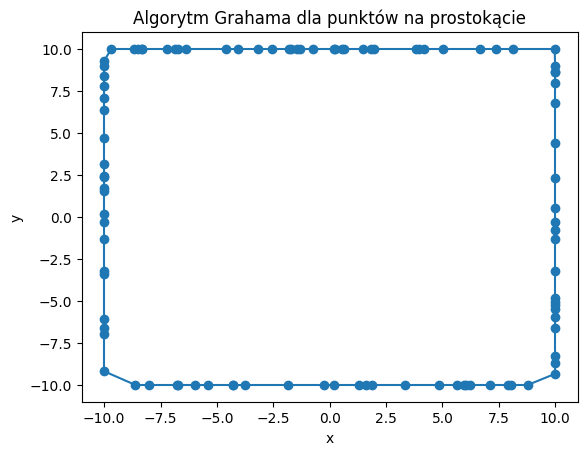

In [28]:
# visualize(graham_points_c)
vis.clear()
vis.add_title("Algorytm Grahama dla punktów na prostokącie")
vis.add_point(points_c)
vis.add_line_segment([(graham_points_c[i], graham_points_c[i+1]) for i in range(len(graham_points_c)-1)])
vis.add_line_segment([graham_points_c[-1], graham_points_c[0]])
vis.show()

Zbiór danych D

In [29]:
graham_points_d, vis_graham_d = graham_algorithm_draw(points_d[:])

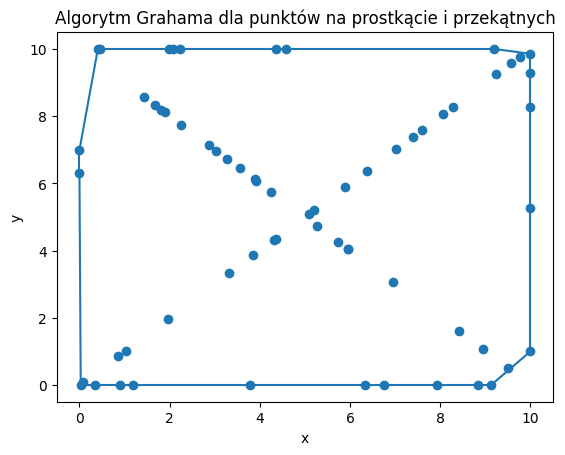

In [30]:
# visualize(graham_points_d)
vis.clear()
vis.add_title("Algorytm Grahama dla punktów na prostkącie i przekątnych")
vis.add_point(points_d)
vis.add_line_segment([(graham_points_d[i], graham_points_d[i+1]) for i in range(len(graham_points_d)-1)])
vis.add_line_segment([graham_points_d[-1], graham_points_d[0]])
vis.show()

### Algorytm Jarvisa

Algorytm Jarvisa oblicza otoczkę wypukłą dla zbioru punktów $Q$ przez technikę zwaną owijaniem paczki (*package wrapping*) lub owijaniem prezentu (*gift wrapping*). Algorytm Jarvisa buduje sekwencję $H = \langle p_1, p_2, \dots, p_m \rangle$ będącą wierzchołkami $\mathcal{CH}(Q)$. Zaczynamy od punktu $p_0$, następny punkt $p_1$ w otoczce wypukłej ma najmniejszy kąt w odniesieniu do $p_0$ (w przypadku takiego samego kąta - wybiera się punkt najdalej od $p_0$). Podobnie, gdy $p_2$ ma najmniejszy kąt w odniesieniu do $p_1$, itd.. Zauważyć warto, że możemy tym sposobem obliczyć lewy i prawy łańcuch otoczki wypukłej $\mathcal{CH}(Q)$. Lewy łańcuch buduje się podobnie. Gdy osiągniemy najwyższy wierzchołej w prawym łańcuchu $p_k$, wybieramy wierzchołek $p_{k+1}$, który ma najmniejszy kąt w odniesieniu do $p_k$, ale od ujemnej osi-$x$. Można zaimplementować algorytm Jarvisa bez konstruowania pomocniczych łańcuchów - lewego i prawego. Taka implementacja utrzymuje śledzenie kąta ostatniej strony otoczki wypukłej i wymaga sekwencji kątów boków otoczki tylko rosnącej. (Patrząc na trzy ostatnie punkty jesteśmy w stanie obliczyć jaki punkt należy włączyć do $\mathcal{CH}(Q)$ w zależności od budowanego punktu)

<span style="color:red">Ćw.</span> Uzupełnij funkcję ```jarvis_algorithm```, która oblicza otoczkę wypukłą korzystając z algorytmu Jarvisa.

In [31]:
def jarvis_algorithm(Q):
    '''
    Funkcja buduje otoczkę wypukłą dla podanego
    zbioru punktów Q algorymem Jarvisa
    :param Q: zbiór punktów
    :return: tablica punktów w postaci krotek współrzędnych
    '''

    start_point = Q[find_leftmost(Q)]
    stack = [start_point]
    loop = True
    while loop:
        p0 = stack[-1]
        next_point = Q[0]
        for new_point in Q[1:]:
            if cmp(p0, next_point, new_point) > 0 or (cmp(p0, next_point, new_point) == 0 and dist(p0, next_point) < dist(p0, new_point)):
                next_point = new_point


        if next_point[0] == stack[0][0] and next_point[1] == stack[0][1]:
            loop = False
        else:
            stack.append(next_point)
        
    return stack
            

Przetestuj swoją implementacje algorytmu Jarvisa, by sprawdzić czy poprawnie obliczana jest otoczka.

In [32]:
Test().runtest(2, jarvis_algorithm)

Lab 2, task 2:
	Test 1: Passed
	Test 2: Passed
	Test 3: Passed
	Test 4: Passed
	Test 5: Passed
	Test 6: Passed
	Test 7: Passed
	Test 8: Passed
	Test 9: Passed
	Test 10: Passed
	Test 11: Passed
Result: 11/11
Time: 2.405s


<span style="color:red">Ćw.</span> Uzupełnij funkcję ```jarvis_algorithm_draw```, która oblicza otoczkę wypukłą korzystając z algorytmu Jarvisa z dodatkową opcją wyświetlania kroków algorytmu.

In [36]:
def jarvis_algorithm_draw(Q):
    '''
    Funkcja buduje otoczkę wypukłą dla podanego
    zbioru punktów Q algorymem Jarvisa oraz 
    pokazuje poszczególne kroki algorymu
    :param Q: zbiór punktów
    :return: krotka w postaci  (tablica punktów w postaci krotek współrzędnych,
                                wizualizer pokazujący kroki algorytmu) 
    '''
    vis = Visualizer()
    vis.add_title("Sposób działania algorytmu Jarvisa")
    vis.add_point(Q, color='blue', s=10)
    
    
    start_point = Q[find_leftmost(Q)]

    vis.add_point(start_point, color='red', s=10)
    
    stack = [start_point]
    loop = True
    while loop:
        p0 = stack[-1]
        next_point = Q[0]
        vis_next_point = vis.add_point(next_point, color='green', s=10)
        vis_line = vis.add_line([p0, next_point], color='green')

        for new_point in Q[1:]:
            vis_new_point_line = vis.add_line_segment([next_point, new_point], color='green')
            if cmp(p0, next_point, new_point) > 0 or (cmp(p0, next_point, new_point) == 0 and dist(p0, next_point) < dist(p0, new_point)):
                next_point = new_point
                vis.remove_figure(vis_line)
                vis.remove_figure(vis_next_point)

                vis_next_point = vis.add_point(next_point, color='green', s=10)
                vis_line = vis.add_line([p0, next_point], color='green')
            
            vis.remove_figure(vis_new_point_line)
        vis.remove_figure(vis_line)
    
        if next_point[0] == stack[0][0] and next_point[1] == stack[0][1]:
            loop = False
            vis.add_line_segment([stack[-1], stack[0]], color='red')
        else:
            stack.append(next_point)
            vis.add_point(stack[-1], color='red')#, s=10)
            vis.add_line_segment([stack[-2], stack[-1]], color='red')
        
    return stack, vis

Zwizualizuj swoją implementację algorytmu.

Zbiór danych A

In [37]:
jarvis_points_a, vis_jarvis_a = jarvis_algorithm_draw(points_a[:])

In [38]:
vis_jarvis_a.save_gif(filename='jarvis_plane', interval=100)#show_gif(interval=100)

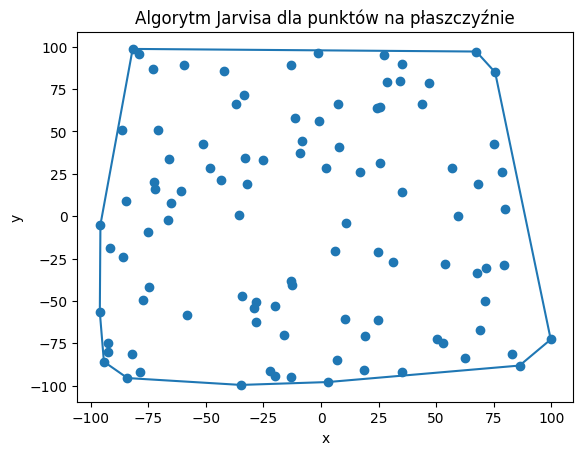

In [39]:
# visualize(jarvis_points_a)
vis.clear()
vis.add_title("Algorytm Jarvisa dla punktów na płaszczyźnie")
vis.add_point(points_a)
vis.add_line_segment([(jarvis_points_a[i], jarvis_points_a[i+1]) for i in range(len(jarvis_points_a)-1)])
vis.add_line_segment([jarvis_points_a[-1], jarvis_points_a[0]])
vis.show()

Zbiór danych B

In [40]:
jarvis_points_b, vis_jarvis_b = jarvis_algorithm_draw(points_b[:])

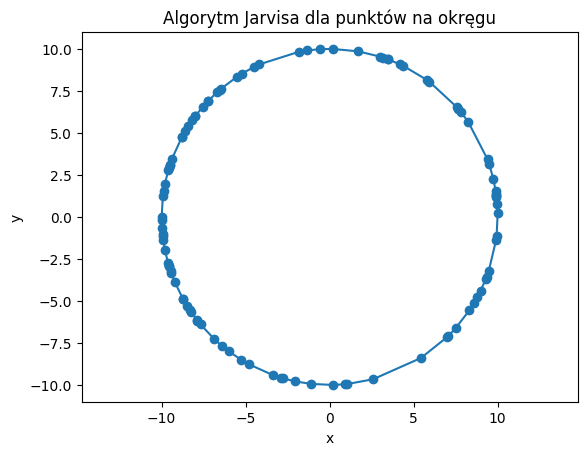

In [42]:
# visualize(jarvis_points_b)
vis.clear()
vis.add_title("Algorytm Jarvisa dla punktów na okręgu")
vis.add_point(points_b)
vis.add_line_segment([(jarvis_points_b[i], jarvis_points_b[i+1]) for i in range(len(jarvis_points_b)-1)])
vis.add_line_segment([jarvis_points_b[-1], jarvis_points_b[0]])
vis.axis_equal()
vis.show()

Zbiór danych C

In [44]:
jarvis_points_c, vis_jarvis_c = jarvis_algorithm_draw(points_c[:])

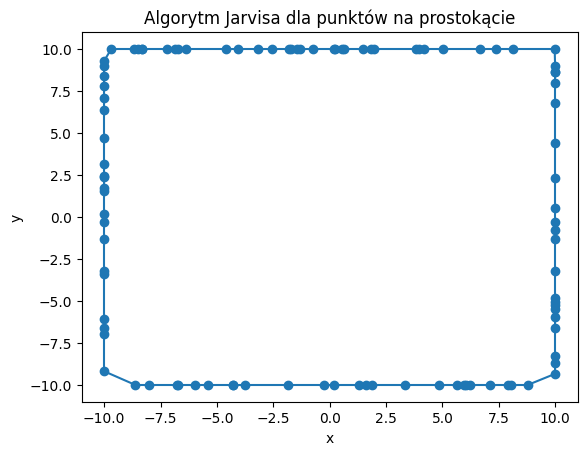

In [45]:
# visualize(jarvis_points_c)
vis.clear()
vis.add_title("Algorytm Jarvisa dla punktów na prostokącie")
vis.add_point(points_c)
vis.add_line_segment([(jarvis_points_c[i], jarvis_points_c[i+1]) for i in range(len(jarvis_points_c)-1)])
vis.add_line_segment([jarvis_points_c[-1], jarvis_points_c[0]])
vis.show()

Zbiór danych D

In [46]:
jarvis_points_d, vis_jarvis_d = jarvis_algorithm_draw(points_d[:])

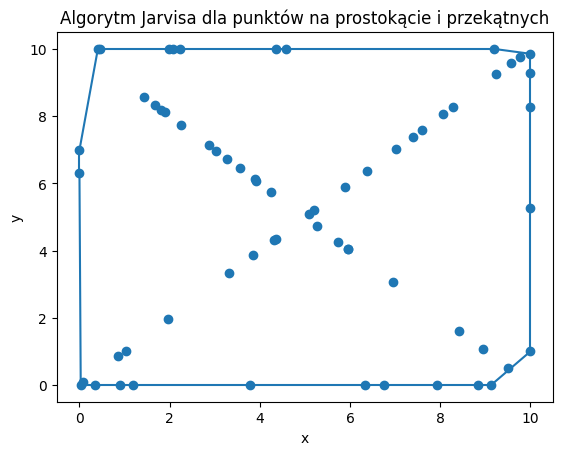

In [47]:
# visualize(jarvis_points_d)
vis.clear()
vis.add_title("Algorytm Jarvisa dla punktów na prostokącie i przekątnych")
vis.add_point(points_d)
vis.add_line_segment([(jarvis_points_d[i], jarvis_points_d[i+1]) for i in range(len(jarvis_points_d)-1)])
vis.add_line_segment([jarvis_points_d[-1], jarvis_points_d[0]])
vis.show()


---

Po zobaczeniu i przetestowaniu wstępnie zbiorów danych, przyszła kolej na porównanie czasów działania dla różnych danych. Do tego potrzebujemy bardziej miarodajnych zbiorów danych.  
<span style="color:red">Ćw.</span> Stwórz zmodyfikowane zbiory danych A, B, C oraz D - tak jak uważasz za słuszne.

In [24]:
comparison_df = pd.DataFrame(columns=["algorithm", "points_set", "points_size", "time"])

def n_range():
    n = 1e3
    for i in range(10):
        yield int(n)
        n += 1e3

def add_test(comparison_df, points_set, points_size, algorithm, df_dict):
    timer_start = process_time()
    _ = algorithm(points_set)
    timer_stop = process_time()
    df_dict["time"] = timer_stop-timer_start
    comparison_df.loc[len(comparison_df)] = df_dict
    

for n in n_range():
    points_a = generate_uniform_points(-100000, 100000, n)
    add_test(comparison_df, points_a[:], n, graham_algorithm, {"algorithm": "graham", "points_set": "points_a", "points_size": n})
    add_test(comparison_df, points_a[:], n, jarvis_algorithm, {"algorithm": "jarvis", "points_set": "points_a", "points_size": n})
    
    
    points_b = generate_circle_points((0, 0), 100000, n)
    add_test(comparison_df, points_b[:], n, graham_algorithm, {"algorithm": "graham", "points_set": "points_b", "points_size": n})
    add_test(comparison_df, points_b[:], n, jarvis_algorithm, {"algorithm": "jarvis", "points_set": "points_b", "points_size": n})
    
    points_c = generate_rectangle_points((-10000000, -10000000), (10000000, -10000000), (10000000, 10000000), (-10000000, 10000000), n)
    add_test(comparison_df, points_c[:], n, graham_algorithm, {"algorithm": "graham", "points_set": "points_c", "points_size": n})
    add_test(comparison_df, points_c[:], n, jarvis_algorithm, {"algorithm": "jarvis", "points_set": "points_c", "points_size": n})
    
    points_d = generate_square_points((-10000000, -10000000), (10000000, -10000000), (10000000, 10000000), (-10000000, 10000000), n//2, n//2)
    add_test(comparison_df, points_d[:], n, graham_algorithm, {"algorithm": "graham", "points_set": "points_d", "points_size": n})
    add_test(comparison_df, points_d[:], n, jarvis_algorithm, {"algorithm": "jarvis", "points_set": "points_d", "points_size": n})


Po przygotowaniu zbioru danych, dokonaj porównania czasowego  
<span style="color:red">Ćw.</span> Porównaj zmodyfikowane zbiory danych A, B, C oraz D dla algorytmów Grahama i Jarvisa.

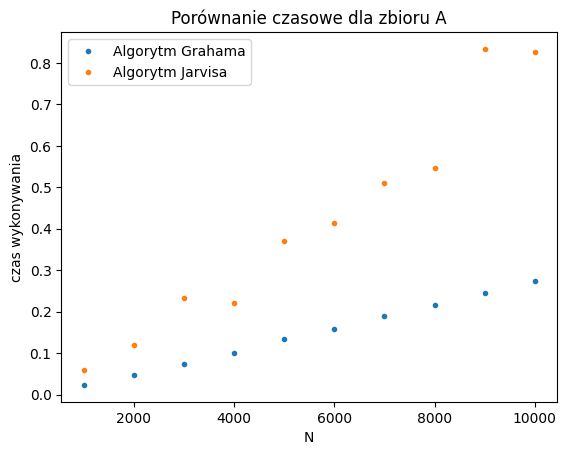

In [25]:
points_graham = comparison_df.loc[(comparison_df["points_set"] == "points_a") & (comparison_df["algorithm"] == "graham")]
points_jarvis = comparison_df.loc[(comparison_df["points_set"] == "points_a") & (comparison_df["algorithm"] == "jarvis")]

plt.title("Porównanie czasowe dla zbioru A")
plt.xlabel("N")
plt.ylabel("czas wykonywania")

plt.plot(points_graham["points_size"], points_graham["time"], '.', label = "Algorytm Grahama")
plt.plot(points_jarvis["points_size"], points_jarvis["time"], '.', label = "Algorytm Jarvisa")
plt.legend()

plt.show()#savefig("time_cmp_a")

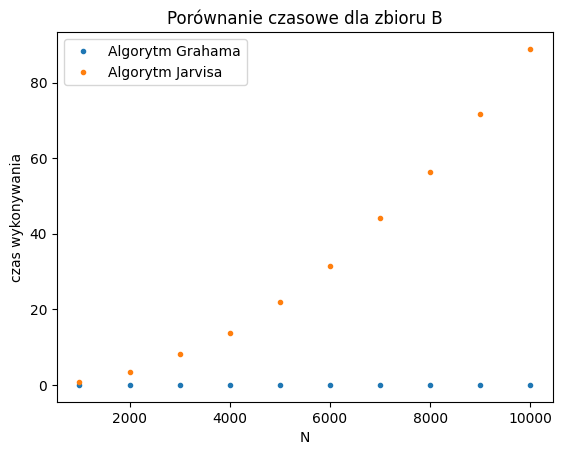

In [71]:
points_graham = comparison_df.loc[(comparison_df["points_set"] == "points_b") & (comparison_df["algorithm"] == "graham")]
points_jarvis = comparison_df.loc[(comparison_df["points_set"] == "points_b") & (comparison_df["algorithm"] == "jarvis")]
plt.cla()
plt.title("Porównanie czasowe dla zbioru B")
plt.xlabel("N")
plt.ylabel("czas wykonywania")

plt.plot(points_graham["points_size"], points_graham["time"], '.', label = "Algorytm Grahama")
plt.plot(points_jarvis["points_size"], points_jarvis["time"], '.', label = "Algorytm Jarvisa")
plt.legend()

plt.show()#savefig("time_cmp_b")

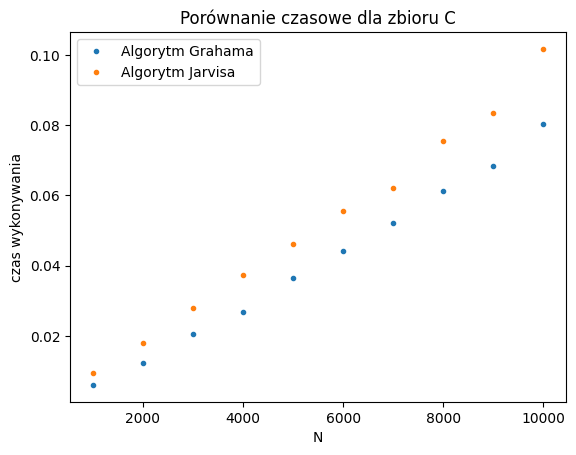

In [70]:
points_graham = comparison_df.loc[(comparison_df["points_set"] == "points_c") & (comparison_df["algorithm"] == "graham")]
points_jarvis = comparison_df.loc[(comparison_df["points_set"] == "points_c") & (comparison_df["algorithm"] == "jarvis")]

plt.cla()
plt.title("Porównanie czasowe dla zbioru C")
plt.xlabel("N")
plt.ylabel("czas wykonywania")

plt.plot(points_graham["points_size"], points_graham["time"], '.', label = "Algorytm Grahama")
plt.plot(points_jarvis["points_size"], points_jarvis["time"], '.', label = "Algorytm Jarvisa")
plt.legend()

plt.show()#savefig("time_cmp_c")

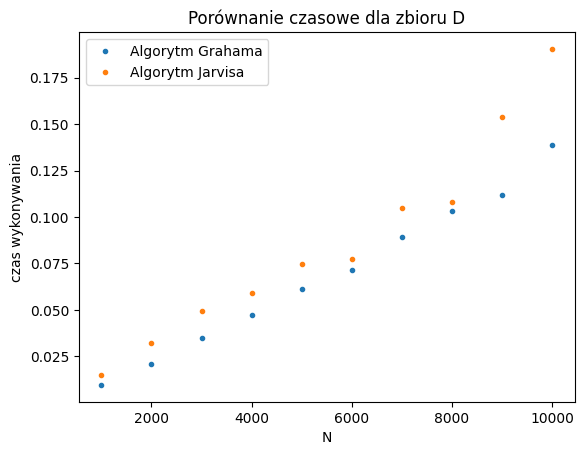

In [69]:
points_graham = comparison_df.loc[(comparison_df["points_set"] == "points_d") & (comparison_df["algorithm"] == "graham")]
points_jarvis = comparison_df.loc[(comparison_df["points_set"] == "points_d") & (comparison_df["algorithm"] == "jarvis")]

plt.title("Porównanie czasowe dla zbioru D")
plt.xlabel("N")
plt.ylabel("czas wykonywania")

plt.plot(points_graham["points_size"], points_graham["time"], '.', label = "Algorytm Grahama")
plt.plot(points_jarvis["points_size"], points_jarvis["time"], '.', label = "Algorytm Jarvisa")
plt.legend()

plt.show()#savefig("time_cmp_d")

Bibliografia:
- Wprowadzenie do algorytmów wydanie 3, Thomas H. Cormen, Charles E. Leiserson, Ronald L. Rivest, Stein Clifford
